In [10]:
# Imports and plotting setups
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sys, os

import math_funcs

from cycler import cycler

default_cycler = (cycler(color=['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']) +
                cycler(linestyle=['-', '--', ':', '-.', '-', '--', ':']))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

plt.rcParams["font.family"] = "Times"
plt.rcParams["font.size"] = 8

plt.rcParams['figure.figsize'] = (5.5, 2.5)
plt.rcParams['figure.dpi'] = 600

plt.rcParams['text.usetex'] = True

from utils import *

In [11]:
class hf():
    hackrf_noise_figure = 11 # dB
    transmit_power = 30 # dBm
    brightness_temperature_downwelling = 2.9e6
    brightness_temperature_upwelling = 290
    antenna_noise_temperature = brightness_temperature_downwelling * 0.75 + brightness_temperature_upwelling * 0.25
    antenna_physical_temperature = 273
    receiver_physical_temperature = 290
    receiver_bw = 10e3

class uhf():
    hackrf_noise_figure = 10 # dB
    transmit_power = 30 # dBm
    brightness_temperature_downwelling = 29
    brightness_temperature_upwelling = 290
    antenna_noise_temperature = brightness_temperature_downwelling * 0.25 + brightness_temperature_upwelling * 0.75
    antenna_physical_temperature = 273
    receiver_physical_temperature = 290
    receiver_bw = 10e3

discretization_distance = 10 # m
distance = 1e3 # m

In [12]:
link_df = pd.DataFrame({'Distance':np.arange(0, distance, discretization_distance)+discretization_distance})

link_df['T(K)'] = 273

link_df['UHF Ice Wave Number'] = ice_wave_number(uhf_antenna.carrier_frequency, link_df['T(K)'])
link_df['UHF Discretized Linear Loss'] = np.e**(2 * discretization_distance * np.imag(link_df['UHF Ice Wave Number']))
link_df['UHF Linear Loss'] = link_df['UHF Discretized Linear Loss'].cumprod()
link_df['UHF Phase Number'] = np.real(link_df['UHF Ice Wave Number']) * discretization_distance
link_df['UHF Cumulative Phase Number'] = link_df['UHF Phase Number'].cumsum()
link_df['UHF Space Path Loss'] = (1 / (2 * link_df['UHF Cumulative Phase Number']))**2
link_df['UHF Total Loss (dB)'] = 10 * np.log10(link_df['UHF Space Path Loss'] * link_df['UHF Linear Loss'])
link_df['Compared space path loss'] = 10 * np.log10((1 / (2 * np.real(link_df['UHF Ice Wave Number']) * (link_df['Distance'])))**2)

link_df['HF Ice Wave Number'] = ice_wave_number(hf_antenna.carrier_frequency, link_df['T(K)'])
link_df['HF Discretized Linear Loss'] = np.e**(2 * discretization_distance * np.imag(link_df['HF Ice Wave Number']))
link_df['HF Linear Loss'] = link_df['HF Discretized Linear Loss'].cumprod()
link_df['HF Phase Number'] = np.real(link_df['HF Ice Wave Number']) * discretization_distance
link_df['HF Cumulative Phase Number'] = link_df['HF Phase Number'].cumsum()
link_df['HF Space Path Loss'] = (1 / (2 * link_df['HF Cumulative Phase Number']))**2 
link_df['HF Total Loss (dB)'] = 10 * np.log10(link_df['HF Space Path Loss'] * link_df['HF Linear Loss'])
#(1 / (2 * np.real(link_df['HF Ice Wave Number']) * (link_df['Distance'])))**2

link_df


,Distance,T(K),UHF Ice Wave Number,UHF Discretized Linear Loss,UHF Linear Loss,UHF Phase Number,UHF Cumulative Phase Number,UHF Space Path Loss,UHF Total Loss (dB),Compared space path loss,HF Ice Wave Number,HF Discretized Linear Loss,HF Linear Loss,HF Phase Number,HF Cumulative Phase Number,HF Space Path Loss,HF Total Loss (dB)
0,10.0,273,15.455660- 0.002344j,0.954197,0.954197,154.556604,154.556604,1.046562e-05,-50.005969,-49.802351,0.201073-0.000030j,0.99939,0.999390,2.010733,2.010733,0.061835,-12.090336
1,20.0,273,15.455660- 0.002344j,0.954197,0.910493,154.556604,309.113207,2.616404e-06,-56.230187,-55.822951,0.201073-0.000030j,0.99939,0.998781,2.010733,4.021466,0.015459,-18.113585
2,30.0,273,15.455660- 0.002344j,0.954197,0.868790,154.556604,463.669811,1.162846e-06,-59.955630,-59.344776,0.201073-0.000030j,0.99939,0.998172,2.010733,6.032198,0.006871,-21.638059
3,40.0,273,15.455660- 0.002344j,0.954197,0.828997,154.556604,618.226414,6.541011e-07,-62.658023,-61.843551,0.201073-0.000030j,0.99939,0.997563,2.010733,8.042931,0.003865,-24.139483
4,50.0,273,15.455660- 0.002344j,0.954197,0.791026,154.556604,772.783018,4.186247e-07,-64.799841,-63.781751,0.201073-0.000030j,0.99939,0.996955,2.010733,10.053664,0.002473,-26.080332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,960.0,273,15.455660- 0.002344j,0.954197,0.011099,154.556604,14837.433938,1.135592e-09,-108.995104,-89.447776,0.201073-0.000030j,0.99939,0.943126,2.010733,193.030345,0.000007,-51.987416
96,970.0,273,15.455660- 0.002344j,0.954197,0.010590,154.556604,14991.990542,1.112299e-09,-109.288732,-89.537786,0.201073-0.000030j,0.99939,0.942551,2.010733,195.041078,0.000007,-52.080075
97,980.0,273,15.455660- 0.002344j,0.954197,0.010105,154.556604,15146.547146,1.089714e-09,-109.581437,-89.626873,0.201073-0.000030j,0.99939,0.941976,2.010733,197.051811,0.000006,-52.171811
98,990.0,273,15.455660- 0.002344j,0.954197,0.009642,154.556604,15301.103749,1.067811e-09,-109.873238,-89.715055,0.201073-0.000030j,0.99939,0.941401,2.010733,199.062543,0.000006,-52.262642


In [13]:
uhf_receiver_transmitter_contribution_only = 2 * 10 * np.log10(uhf_antenna.match_efficiency) \
    + 2 * 10 * np.log10(uhf_antenna.radiation_efficiency(273)) \
    + 2 * uhf_antenna.directivity(273) \

hf_receiver_transmitter_contribution_only =  2 * 10 * np.log10(hf_antenna.match_efficiency) \
    + 2 * 10 * np.log10(hf_antenna.radiation_efficiency) \
    + 2 * hf_antenna.directivity \
    
uhf_receiver_transmitter_contribution_only, 2 * 10 * np.log10(uhf_antenna.radiation_efficiency(273)), hf_receiver_transmitter_contribution_only

(-7.683476409826758, -12.841303059990922, -39.09803919971486)

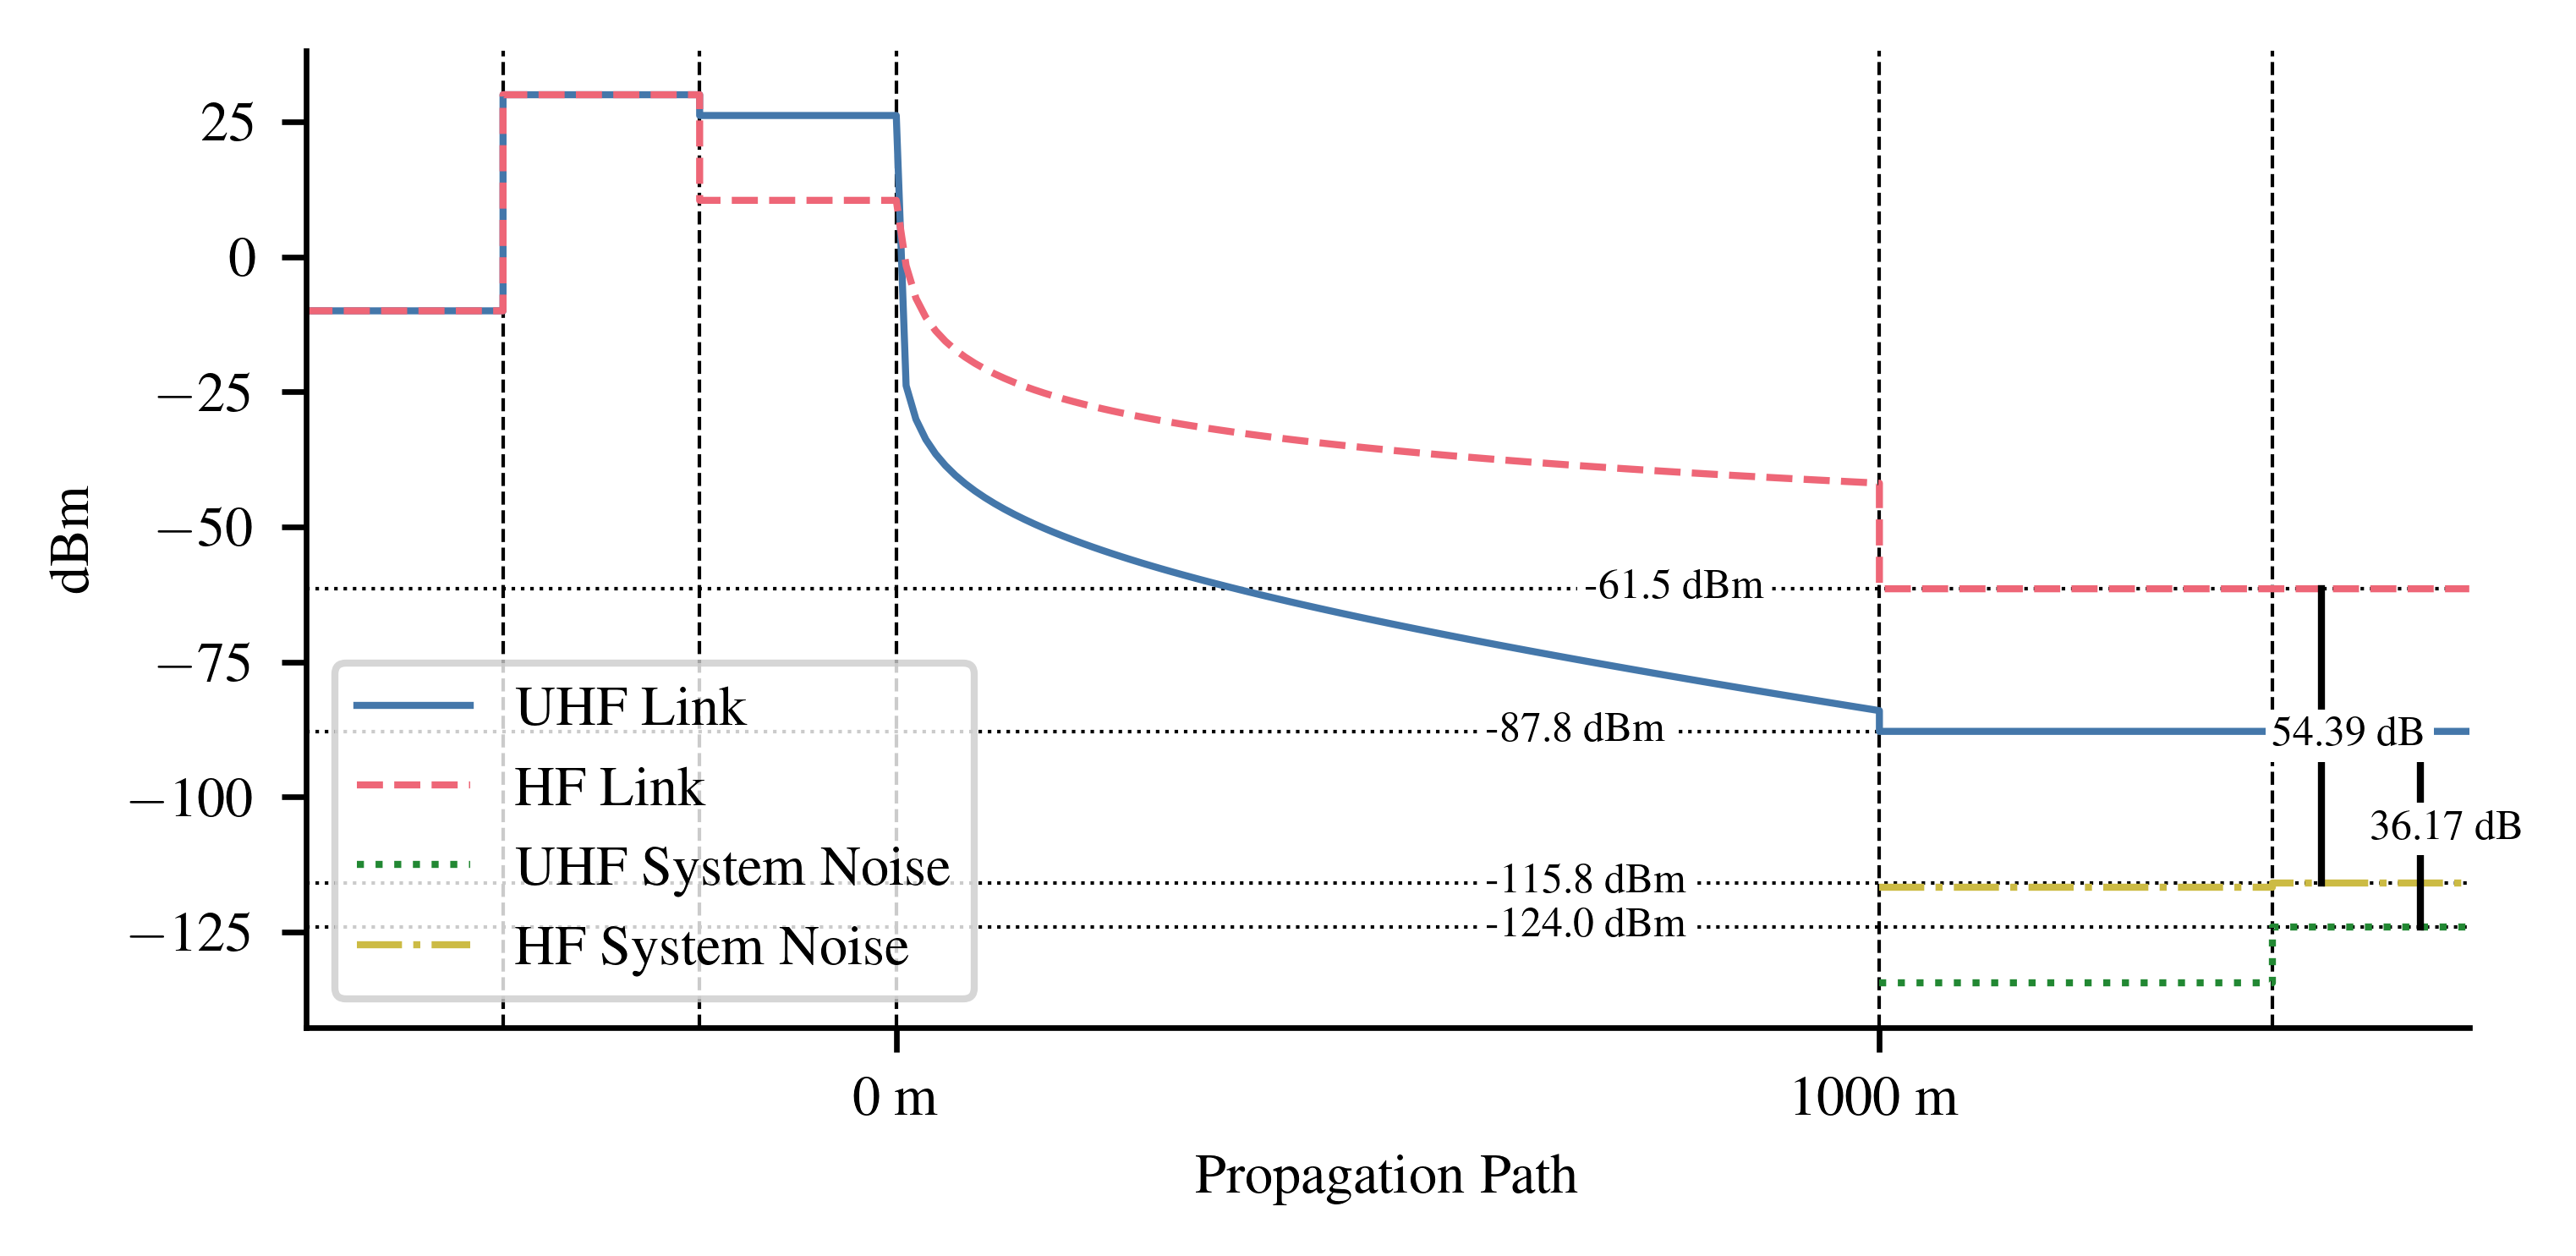

In [22]:
plt.figure()

uhf_EIRP = \
    uhf.transmit_power \
    + 10 * np.log10(uhf_antenna.match_efficiency) \
    + 10 * np.log10(uhf_antenna.radiation_efficiency(273)) \
    + uhf_antenna.directivity(273)

uhf_received_power = \
    uhf.transmit_power \
    + 2 * 10 * np.log10(uhf_antenna.match_efficiency) \
    + 2 * 10 * np.log10(uhf_antenna.radiation_efficiency(273)) \
    + 2 * uhf_antenna.directivity(273) \
    + link_df['UHF Total Loss (dB)'].min()

hf_EIRP = \
    hf.transmit_power \
    + 10 * np.log10(hf_antenna.match_efficiency) \
    + 10 * np.log10(hf_antenna.radiation_efficiency) \
    + hf_antenna.directivity

hf_received_power = \
    hf.transmit_power \
    + 2 * 10 * np.log10(hf_antenna.match_efficiency) \
    + 2 * 10 * np.log10(hf_antenna.radiation_efficiency) \
    + 2 * hf_antenna.directivity \
    + link_df['HF Total Loss (dB)'].min()

def noise_temperature_to_noise_power(noise_temperature, bandwidth):
    """Converts noise temperature to power in dBm

    Args:
        noise_temperature (float): Noise temperature in Kelvin
        bandwidth (float): Bandwidth of the receiver

    Returns:
        float: Noise power in dBm
    """
    return 10 * np.log10(noise_temperature * k * bandwidth) + 30

uhf_receiver_noise_temperature = 290 * (10**(uhf.hackrf_noise_figure/10) - 1)
uhf_antenna_terminal_noise_temperature = \
    uhf_antenna.radiation_efficiency(273) * uhf_antenna.match_efficiency * uhf.antenna_noise_temperature \
    + (1 - uhf_antenna.radiation_efficiency(273)) * uhf_antenna.match_efficiency * uhf.antenna_physical_temperature \
    + (1 - uhf_antenna.match_efficiency) * uhf.receiver_physical_temperature
uhf_antenna_terminal_noise_power = noise_temperature_to_noise_power(
    uhf_antenna_terminal_noise_temperature,
    uhf.receiver_bw
)
uhf_system_noise_power = noise_temperature_to_noise_power(
    (uhf_receiver_noise_temperature + uhf_antenna_terminal_noise_temperature),
    uhf.receiver_bw
)

hf_receiver_noise_temperature = 290 * (10**(hf.hackrf_noise_figure/10) - 1)
hf_antenna_terminal_noise_temperature = \
    hf_antenna.radiation_efficiency * hf_antenna.match_efficiency * hf.antenna_noise_temperature \
    + (1 - hf_antenna.radiation_efficiency) * hf_antenna.match_efficiency * hf.antenna_physical_temperature \
    + (1 - hf_antenna.match_efficiency) * hf.receiver_physical_temperature
hf_antenna_terminal_noise_power = noise_temperature_to_noise_power(
    hf_antenna_terminal_noise_temperature,
    hf.receiver_bw
)
hf_system_noise_power = noise_temperature_to_noise_power(
    (hf_receiver_noise_temperature + hf_antenna_terminal_noise_temperature),
    hf.receiver_bw
)

# Vertical line
plt.axvline(x=-400, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=-200, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=1000, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=1400, color='black', linestyle='--', linewidth=0.5)

plt.axhline(y=hf_received_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    700, 
    hf_received_power, 
    '{0:.1f} dBm'.format(hf_received_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.axhline(y=hf_system_noise_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    600, 
    hf_system_noise_power, 
    '{0:.1f} dBm'.format(hf_system_noise_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.axhline(y=uhf_received_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    600, 
    uhf_received_power, 
    '{0:.1f} dBm'.format(uhf_received_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

plt.axhline(y=uhf_system_noise_power, color='black', linestyle=':', linewidth=0.5)
plt.text(
    600, 
    uhf_system_noise_power, 
    '{0:.1f} dBm'.format(uhf_system_noise_power), 
    color='black', va='center', fontsize=6,
    bbox=dict(facecolor='white', edgecolor='none', pad=1))

# Plot the data
plt.plot(
    [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
    [-10, -10, uhf.transmit_power, uhf.transmit_power, uhf_EIRP, uhf_EIRP] + list(link_df['UHF Total Loss (dB)'] + uhf_EIRP) + [uhf_received_power, uhf_received_power], 
    label='UHF Link')
plt.plot(
    [-600, -400, -400, -200, -200, 0] + list(link_df['Distance']) + [1000, 1600], 
    [-10, -10, hf.transmit_power, hf.transmit_power, hf_EIRP, hf_EIRP] + list(link_df['HF Total Loss (dB)'] + hf_EIRP) + [hf_received_power, hf_received_power], 
    label='HF Link')

plt.plot(
    [1000, 1400, 1400, 1600], [uhf_antenna_terminal_noise_power,uhf_antenna_terminal_noise_power, uhf_system_noise_power, uhf_system_noise_power],
    label='UHF System Noise'
)

plt.plot(
    [1000, 1400, 1400, 1600], [hf_antenna_terminal_noise_power, hf_antenna_terminal_noise_power, hf_system_noise_power, hf_system_noise_power],
    label='HF System Noise'
)

# Plot the SNR
plt.plot([1550, 1550], [uhf_received_power, uhf_system_noise_power], color='black', linestyle='-')
plt.text(
        1500, 
        (uhf_received_power + uhf_system_noise_power) / 2,
        f"{uhf_received_power - uhf_system_noise_power:.2f} dB", 
        color='black', va='center', fontsize=6, 
        bbox=dict(facecolor='white', edgecolor='none', pad=1)
)

plt.plot([1450, 1450], [hf_received_power, hf_system_noise_power], color='black', linestyle='-')
plt.text(
        1400, 
        (hf_received_power + hf_system_noise_power) / 2,
        f"{hf_received_power - hf_system_noise_power:.2f} dB", 
        color='black', va='center', fontsize=6, 
        bbox=dict(facecolor='white', edgecolor='none', pad=1)
)

# X-axis tick marks
ticks = [0, 1000]
labels = [f"{tick} m" for tick in ticks]
plt.xticks(ticks, labels)

# Other chart details
plt.xlabel('Propagation Path')
plt.ylabel('dBm')
plt.legend(loc='lower left')

# Remove the right and top bounding box
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Fix the plot so the xlim spans only the whole data set
ax.set_xlim(-600,1600)
ax.set_ylim()

plt.show()

In [15]:
# Calculate SNR
uhf_received_power - uhf_noise_power, hf_received_power - hf_noise_power

NameError: name 'uhf_noise_power' is not defined